# Preparing Textual Data for Statistics and Machine Learning

In [14]:
!pip install ipynb
from ipynb.fs.full.earlyinsights import count_words

In [2]:
import pandas as pd
import sqlite3
import re
import html
import textacy.preprocessing as tprep
from textacy.preprocessing.replace import RE_URL, replace_urls
import nltk
import spacy
from spacy.tokenizer import Tokenizer
from spacy.util import compile_prefix_regex, compile_infix_regex, compile_suffix_regex
from spacy import displacy
import textacy
from tqdm import tqdm
import math

In [3]:
posts_file = 'rspct_autos.tsv.gz'
posts_df = pd.read_csv(posts_file, sep='\t')

subred_file = 'subreddit_info.csv.gz'
subred_df = pd.read_csv(subred_file).set_index(['subreddit'])

df = posts_df.join(subred_df, on='subreddit')
df.head()

id   subreddit                                     title  \
0  8f73s7      Harley                            No Club Colors   
1  5s0q8r     Mustang                     Roush vs Shleby GT500   
2  5z3405  Volkswagen  2001 Golf Wagon looking for some insight   
3  7df18v       Lexus               IS 250 Coolant Flush/Change   
4  5tpve8        volt                 Gen1 mpg w/ dead battery?   

                                            selftext category_1  \
0  Funny story. I went to college in Las Vegas. T...      autos   
1  I am trying to determine which is faster, and ...      autos   
2  Hello! <lb><lb>Trying to find some information...      autos   
3  https://www.cars.com/articles/how-often-should...      autos   
4  Hi, new to this subreddit.  I'm considering bu...      autos   

        category_2 category_3  in_data reason_for_exclusion  
0  harley davidson        NaN     True                  NaN  
1             ford        NaN     True                  NaN  
2               VW        NaN     True                  NaN  
3            lexus        NaN     True                  NaN  
4        chevrolet        NaN     True                  NaN

## 1. Standardizing Attribute Names

In [4]:
print(df.columns)


Index(['id', 'subreddit', 'title', 'selftext', 'category_1', 'category_2',
       'category_3', 'in_data', 'reason_for_exclusion'],
      dtype='object')


In [5]:
column_mapping = {
    'id': 'id',
    'subreddit': 'subreddit',
    'title': 'title',
    'selftext': 'text',
    'category_1': 'category',
    'category_2': 'subcategory',  
    'category_3': None, # no data
    'in_data': None, # not needed
    'reason_for_exclusion': None # not needed
}

# define remaining columns
columns = [c for c in column_mapping.keys() if column_mapping[c] != None]

# select and rename those columns
df = df[columns].rename(columns=column_mapping)

df = df[df['category'] == 'autos']

In [6]:
pd.options.display.max_colwidth = None ###
df.sample(1, random_state=7).T

14356
id                                                                                                                                                                                                                                                                                                                             7jc2k4
subreddit                                                                                                                                                                                                                                                                                                                        volt
title                                                                                                                                                                                                                                                                                                           Dashcam for 2017 volt
text         Hello.<lb>I'm looking into getting a dashcam. <lb>Does anyone have any recommendations? <lb><lb>I'm generally looking for a rechargeable one so that I don't have to route wires down to the cigarette lighter. <lb>Unless there are instructions on how to wire it properly without wires showing. <lb><lb><lb>Thanks! 
category                                                                                                                                                                                                                                                                                                                        autos
subcategory                                                                                                                                                                                                                                                                                                                 chevrolet

### Saving and loading a DataFrame

In [7]:
df.to_pickle('reddit_dataframe.pkl')


In [8]:
db_name = 'reddit_selfposts.db'
con = sqlite3.connect(db_name)
df.to_sql("posts", con, index=False, if_exists='replace')
con.close()


In [9]:
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts", con)
con.close()

## 2. Identify Noise with Regular Expressions

In [10]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_length=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_length:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)
    
print(impurity(text))

0.09009009009009009


In [11]:
# add new column to dataframe
df['impurity'] = df['text'].apply(impurity, min_length=10)

# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(1)

text  \
19682  Looking at buying a 335i with 39k miles and 11 months left on the CPO warranty. I asked the dealer if the HPFP had been replaced, and for a copy of the service history. He said it had been replaced and provided the service history below. He is saying that the HPFP was replaced in repair order 774680, but isn't the DMTL different than the HPFP, and if the HPFP was also replaced, wouldn't you see it in the order details?<lb><lb>If I can get this HPFP/DMTL issue figured out, what do you think of a 2011 335i w/39k miles, 11 months of CPO and Maintenance for $22k+TTL? It has the Premium and SPort packages, plus the following options:        Heated Front Seats<lb>        harman/kardon Surround Sound System<lb>        Sports Leather Steering Wheel w/Paddle Shifters<lb>        Transmission: 6-Speed STEPTRONIC Automatic<lb>        SIRIUS Satellite Radio<lb><lb>Here's the service history:<lb>ID<lb><tab><lb>Claim<lb>Number<lb><tab><lb>Repair<lb>Order<lb>Number<lb><tab><lb>Repair<lb>Order<lb>Date<lb><tab><lb>Repair<lb>Entry<lb>Date<lb><tab><lb>DAVIS<lb> #<lb><tab><lb>Mileage<lb><tab><tab><lb>Defect Code/Description<lb><tab><lb><tab><tab><tab><lb>40304<lb><tab><lb>01<lb><tab><lb>422970<lb><tab><lb>173659<lb><tab><lb>01/05/2017<lb><tab><lb>01/05/2017<lb><tab><lb>1<lb><tab><lb>37,521<lb><tab><tab><lb>0032350200<lb><tab><lb>Recall 16V071 See Vehicle Comments for information. Recall Fixed<lb><tab><lb><tab><tab><tab><lb>40304<lb><tab><lb>01<lb><tab><lb>403160<lb><tab><lb>169851<lb><tab><lb>11/08/2016<lb><tab><lb>11/16/2016<lb><tab><lb>0<lb><tab><lb>37,494<lb><tab><tab><lb>61610077MP<lb><tab><lb>FT WIPER RUBBER INSERT-MP<lb>85990091MP<lb><tab><lb>OIL SERVICE(MP)AFTER THE 1ST<lb>85990501MP<lb><tab><lb>STANDARD OPERATION MP<lb><tab><lb><tab><tab><tab><lb>42111<lb><tab><lb>01<lb><tab><lb>614430<lb><tab><lb>951915<lb><tab><lb>10/20/2015<lb><tab><lb>10/21/2015<lb><tab><lb>3<lb><tab><lb>31,250<lb><tab><tab><lb>6121001200<lb><tab><lb>Vehicle battery permanent failure<lb><tab><lb><tab><tab><tab><lb>42111<lb><tab><lb>01<lb><tab><lb>565841<lb><tab><lb>943950<lb><tab><lb>08/26/2015<lb><tab><lb>10/13/2015<lb><tab><lb>0<lb><tab><lb>29,901<lb><tab><tab><lb>64310237MP<lb><tab><lb>MICROFILTER REPLACEMENT<lb>85990101MP<lb><tab><lb>VEHICLE CHECK<lb><tab><lb><tab><tab><tab><lb>42111<lb><tab><lb>01<lb><tab><lb>565840<lb><tab><lb>943950<lb><tab><lb>08/26/2015<lb><tab><lb>08/28/2015<lb><tab><lb>0<lb><tab><lb>29,901<lb><tab><tab><lb>61610077MP<lb><tab><lb>FT WIPER RUBBER INSERT-MP<lb>64310237MP<lb><tab><lb>MICROFILTER REPLACEMENT<lb>85990091MP<lb><tab><lb>OIL SERVICE(MP)AFTER THE 1ST<lb>85990101MP<lb><tab><lb>VEHICLE CHECK<lb>85990501MP<lb><tab><lb>STANDARD OPERATION MP<lb><tab><lb><tab><tab><tab><lb>26167<lb><tab><lb>01<lb><tab><lb>71621<lb><tab><lb>426489<lb><tab><lb>02/11/2015<lb><tab><lb>10/13/2015<lb><tab><lb>0<lb><tab><lb>25,774<lb><tab><tab><lb>85990501MP<lb><tab><lb>STANDARD OPERATION MP<lb><tab><lb><tab><tab><tab><lb>26167<lb><tab><lb>01<lb><tab><lb>71630<lb><tab><lb>426489<lb><tab><lb>02/11/2015<lb><tab><lb>02/13/2015<lb><tab><lb>2<lb><tab><lb>25,774<lb><tab><tab><lb>0011270300<lb><tab><lb>B110814: N55 Engine ? Replace VANOS Gear Bolts<lb><tab><lb><tab><tab><tab><lb>26167<lb><tab><lb>01<lb><tab><lb>71620<lb><tab><lb>426489<lb><tab><lb>02/11/2015<lb><tab><lb>02/13/2015<lb><tab><lb>0<lb><tab><lb>25,774<lb><tab><tab><lb>34000077MP<lb><tab><lb>BRAKE FLUID CHANGE- FULL MAINTENANCE PROGRAM<lb>64310237MP<lb><tab><lb>MICROFILTER REPLACEMENT<lb>85100254NA<lb><tab><lb>Vanos Campaign Customer Support Program<lb>85990087MP<lb><tab><lb>MP-LOW MILEAGE ANNUAL OIL SERVICE<lb>85990101MP<lb><tab><lb>VEHICLE CHECK<lb>85990501MP<lb><tab><lb>STANDARD OPERATION MP<lb><tab><lb><tab><tab><tab><lb>26167<lb><tab><lb>01<lb><tab><lb>774680<lb><tab><lb>398493<lb><tab><lb>06/16/2014<lb><tab><lb>06/17/2014<lb><tab><lb>1<lb><tab><lb>18,219<lb><tab><tab><lb>1613051200<lb><tab><lb>**Fuel tank leakage diagnosis module DMTL permanent failure<lb>6131111300**<lb><tab><lb>Switch (c

In [12]:
count_words(df, column='text', preprocess=lambda t: re.findall(r'<[\w/]*>', t))

freq
token        
<lb>   100729
<tab>     642

## 3. Removing Noise with Regular Expressions

In [13]:
def clean(text):
    
    # convert html escapes like &amp; to characters
    text = html.unescape(text)
    
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    
    # markdown URLs like [Some Text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

In [102]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [103]:
clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))

After viewing the PINKIEPOOL Trailer it got me thinking about the best match ups. Here's my take: Deadpool Captain America
Impurity: 0.0


In [104]:
df['clean_text'] = df['text'].map(clean)
df['impurity'] = df['clean_text'].apply(impurity, min_length=20)

df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False)\
                              .head(3)

clean_text  \
14058      Mustang 2018, 2019, or 2020? Must Haves!! 1. Have a Credit score of 780\+ for the best low interest rates! 2. Join a Credit Union to finance the vehicle! 3. Or Find a Lender to finance the vehicle! 4. Downpayment of 20&#37; to the actual vehicle cost! 5. Be 25 years old for a lower price for insurance! 2018 Mustang GT Premium Build and Price on Ford Website Base MSRP— \($40785\) Destination— \($900\) Paint—Shadow Black or Race Red \(Leaning to Race Red to replace the GT and Mustang Logo to red.\) Powertrain—V8 \(Hell\-yeah!!\) Transmission—10\-Speed Selectshift Automatic Transmission \(Automatic type of guy always.\) \($1595\) Packages—401A\-Premium Plus Package \(Yes Please!! Want my digital cluster!!\) \($2200\) Exterior—GT Performance Package \(Definitely gotta have this!\) \($3995\) Active Valve Performance Exhaust \(I get off in the mornings so yeah!\) \($895\) Magneride Damping System \($1695\) Interior—Safe and Smart Package\(Safety First!\) \($1495\) Premium Floor Liners Front and Rear \(Like to keep my future car clean!\) \($120\) Total— \($51700\) NJ STATE SALES TAX of \($51700\) X \(.06625\) = \($3425.125\) = \($55125.13\) These are my preferences when finding a Mustang of my dreams or when 2019 rolls around lol. Considering that I just turned 23, will definitely be waiting till I'm 25 to get better Insurance rates and saving up for a downpayment. Credit Score is mid 700's and trying to get to 780 for even a better interest rate. Feel free to comment on what you think i should be aware of when purchasing a new car, insurance after 25, or just general comment of the selection i made.   
18934                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                At the dealership, they offered an option for foot-well illumination, but I cannot find any reference to this online. Has anyone gotten it? How does it look? Anyone have pictures. Not sure if this link will work, but here goes: https://www.mazdausa.com/shopping-tools/build-and-price/mazda3-hatchback#s=4&tr=Automatic&d=null&t=18M3HTR%7C18M3HTRA&ex=46G&in=V_BX0&p=&ip=&o=ILK&io=   
16505  I am looking at four Caymans, all are in a similar price range. The major differences are the miles, the years, and one isn’t a S. https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterViewInventoryListing.action?sourceContext=usedPaidSearchNoZip&newSearchFromOverviewPage=true&entitySelectingHelper.selectedEntity=d993&entitySelectingHelper.selectedEntity2=&zip=29036&distance=500&searchChanged=true&showNegotiable=true&modelChanged=undefined&filtersModified=true#listing=197702702 https://www.cargurus.com/Cars/inventorylisting/viewDetailsFilterViewInventoryListing.action?sourceContext=usedPaidSearchNoZip&newSearchFromOverviewPage=true&entitySelectingHelper.selectedEntity=d993&entitySelectingHe

## 4. Character Normalization with textacy

In [105]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [106]:
def normalize(text):
    text = tprep.normalize_hyphenated_words(text)
    text = tprep.normalize_quotation_marks(text)
    text = tprep.normalize_unicode(text)
    text = tprep.remove_accents(text)
    return text

In [107]:
print(normalize(text))

The cafe "Saint-Raphael" is located on Cote d'Azur.


## 5. Pattern-Based Data Masking with textacy

In [108]:
count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

freq
token                                                                                             
www.getlowered.com                                                                               3
http://www.ecolamautomotive.com/#!2/kv7fq                                                        2
https://www.reddit.com/r/Jeep/comments/4ux232/just_ordered_an_android_head_unit_joying_jeep/     2

In [109]:
text = "Check out https://spacy.io/usage/spacy-101"

# using default substitution _URL_
print(replace_urls(text))

Check out _URL_


In [110]:
df['clean_text'] = df['clean_text'].map(replace_urls)
df['clean_text'] = df['clean_text'].map(normalize)

In [111]:
df.rename(columns={'text':'raw text', 'clean_text': 'text'}, inplace=True)
df.drop(columns=['impurity'], inplace=True)


In [112]:
con = sqlite3.connect(db_name)
df.to_sql("posts_cleaned", con, index=False, if_exists="replace")
con.close()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2778: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


# TOKENIZATION

In [113]:
text = """
2019-08-10 23:32: @pete/@louis - I don't have a well-designed 
solution for today's problem. The code of module AC68 should be -1. 
Have to think a bit... #goodnight ;-) 😩😬"""

## 6. Tokenization with Regular Expressions

In [114]:
tokens = re.findall(r'\w\w+', text)
print(*tokens, sep='|')

2019|08|10|23|32|pete|louis|don|have|well|designed|solution|for|today|problem|The|code|of|module|AC68|should|be|Have|to|think|bit|goodnight


In [115]:
RE_TOKEN = re.compile(r"""
               ( [#]?[@\w''\.\-\:]*\w     
               | [:;<]\-?[\)/(3]
               | [\U0001F100-\U0001FFFF]
               )
               """, re.VERBOSE)

# 1st line : words, hashtags and email adresses
# 2nd line : coarse patterns for basic text emojis
# 3rd line : coarse code range for unicode emojis

In [116]:
def tokenize(text):
    return RE_TOKEN.findall(text)

tokens = tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


### Tokenizing with NLTK

In [117]:
nltk.download('punkt') 
tokens = nltk.tokenize.word_tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|:|@|pete/|@|louis|-|I|do|n't|have|a|well-designed|solution|for|today|'s|problem|.|The|code|of|module|AC68|should|be|-1|.|Have|to|think|a|bit|...|#|goodnight|;|-|)|😩😬


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/damienmellot/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [118]:
tokenizer = nltk.tokenize.RegexpTokenizer(RE_TOKEN.pattern, flags=re.VERBOSE)
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23:32|@pete|@louis|I|don't|have|a|well-designed|solution|for|today's|problem|The|code|of|module|AC68|should|be|-1|Have|to|think|a|bit|#goodnight|;-)|😩|😬


In [119]:
tokenizer = nltk.tokenize.TweetTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-|10|23:32|:|@pete|/|@louis|-|I|don't|have|a|well-designed|solution|for|today's|problem|.|The|code|of|module|AC68|should|be|-|1|.|Have|to|think|a|bit|...|#goodnight|;-)|😩|😬


In [120]:
tokenizer = nltk.tokenize.ToktokTokenizer()
tokens = tokenizer.tokenize(text)
print(*tokens, sep='|')

2019-08-10|23|:|32|:|@pete/@louis|-|I|don|'|t|have|a|well-designed|solution|for|today|'|s|problem.|The|code|of|module|AC68|should|be|-1.|Have|to|think|a|bit|...|#goodnight|;|-|)|😩😬


### Linguistic Processing with Spacy

#### Instantiating a Pipeline

In [121]:
nlp = spacy.load('en_core_web_sm')
#nlp = spacy.load('en_core_web_sm', disable=["parser", "ner"])
#nlp.make_doc
nlp.pipeline

[('tagger', <spacy.pipeline.pipes.Tagger at 0x7fc29a020a60>),
 ('parser', <spacy.pipeline.pipes.DependencyParser at 0x7fc3150dbc40>),
 ('ner', <spacy.pipeline.pipes.EntityRecognizer at 0x7fc3150db100>)]

#### Processing Text

In [122]:
nlp = spacy.load('en_core_web_sm')
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

for token in doc:
    print(token, end="|")

In [123]:
def display_nlp(doc, include_punct=False):
    """Generate data from visualization of spacy tokens"""
    rows = []
    for i, t in enumerate(doc):
        if not t.is_punct or include_punct:
            row = {'token': i,  'text': t.text, 'lemma_': t.lemma_, 
                   'is_stop': t.is_stop, 'is_alpha': t.is_alpha,
                   'pos_': t.pos_, 'dep_': t.dep_, 
                   'ent_type_': t.ent_type_, 'ent_iob_': t.ent_iob_}
            rows.append(row)
    
    df = pd.DataFrame(rows).set_index('token')
    df.index_name = None
    return df

In [124]:
display_nlp(doc)

text     lemma_  is_stop  is_alpha   pos_      dep_ ent_type_  \
token                                                                       
0             My     -PRON-     True      True    DET      poss             
1           best       good    False      True    ADJ      amod             
2         friend     friend    False      True   NOUN     nsubj             
3           Ryan       Ryan    False      True  PROPN  compound    PERSON   
4         Peters     Peters    False      True  PROPN     appos    PERSON   
5          likes       like    False      True   VERB      ROOT             
6          fancy      fancy    False      True    ADJ      amod             
7      adventure  adventure    False      True   NOUN  compound             
8          games       game    False      True   NOUN      dobj             

      ent_iob_  
token           
0            O  
1            O  
2            O  
3            B  
4            I  
5            O  
6            O  
7            O  
8            O

## 7. Customizing Tokenization

In [125]:
text = "@Pete: choose low-carb #food #eat-smart. _url_ ;-) 😋👍"
doc = nlp(text)

In [126]:
for token in doc:
    print(token, end='|')

@Pete|:|choose|low|-|carb|#|food|#|eat|-|smart|.|_|url|_|;-)|😋|👍|

In [127]:
def custom_tokenizer(nlp):
    
    # use default patterns except the one matched by re.search
    prefixes = [pattern for pattern in nlp.Defaults.prefixes
                if pattern not in ['-','_','#']]
    suffixes = [pattern for pattern in nlp.Defaults.suffixes
                if pattern not in ['_']]
    infixes = [pattern for pattern in nlp.Defaults.infixes
               if not re.search(pattern, 'xx-xx')]
    
    return Tokenizer(vocab           = nlp.vocab,
                     rules           = nlp.Defaults.tokenizer_exceptions,
                     prefix_search   = compile_prefix_regex(prefixes).search,
                     suffix_search   = compile_suffix_regex(suffixes).search,
                     infix_finditer  = compile_infix_regex(infixes).finditer,
                     token_match     = nlp.Defaults.token_match)

In [128]:
nlp = spacy.load('en_core_web_sm')

In [129]:
nlp.tokenizer = custom_tokenizer(nlp)

In [130]:
doc = nlp(text)
for token in doc:
    print(token, end='|')

@Pete|:|choose|low-carb|#food|#eat-smart|.|_url_|;-)|😋|👍|

## 8. Working with Stop Words

In [131]:
nlp = spacy.load('en_core_web_sm')
text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)

In [132]:
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Dear, Ryan, need, sit, talk, Regards, Pete]


In [133]:
nlp = spacy.load('en_core_web_sm')
nlp.vocab['down'].is_stop = False
nlp.vocab['Dear'].is_stop = True
nlp.vocab['Regards'].is_stop = True

text = "Dear Ryan, we need to sit down and talk. Regards, Pete"
doc = nlp(text)
non_stop = [t for t in doc if not t.is_stop and not t.is_punct]
print(non_stop)

[Ryan, need, sit, down, talk, Pete]


## 9. Extracting Lemmas Based on Part of Speech

In [134]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [135]:
print(*[t.lemma_ for t in doc], sep='|')

-PRON-|good|friend|Ryan|Peters|like|fancy|adventure|game|.


In [136]:
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

[friend, Ryan, Peters, adventure, games]


In [137]:
tokens = textacy.extract.words(doc,
            filter_stops = True,            # default True, no stopwords
            filter_punct = True,            # default True, no punctuation
            filter_nums = True,             # default False, no numbers
            include_pos = ['ADJ', 'NOUN'],  # default None = include all
            exclude_pos = None,             # default None = exclude none
            min_freq = 1)                   # minimum frequency of words

print(*[t for t in tokens], sep='|')

best|friend|fancy|adventure|games


In [138]:
def extract_lemmas(doc, **kwargs):
    return [t.lemma_ for t in textacy.extract.words(doc, **kwargs)]

lemmas = extract_lemmas(doc, include_pos=['ADJ', 'NOUN'])
print(*lemmas, sep='|')

good|friend|fancy|adventure|game


## 10. Extracting Noun Phrases

In [139]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [140]:
patterns = ["POS:ADJ POS:NOUN:+"]
spans = textacy.extract.matches(doc, patterns=patterns)
print(*[s.lemma_ for s in spans], sep='|')

good friend|fancy adventure|fancy adventure game


In [141]:
print(*doc.noun_chunks, sep='|')

My best friend|Ryan Peters|fancy adventure games


In [142]:
def extract_noun_phrases(doc, preceding_pos=['NOUN'], sep='_'):
    patterns=[]
    for pos in preceding_pos:
        patterns.append(f"POS:{pos} POS:NOUN:+")
        spans = textacy.extract.matches(doc, patterns=patterns)
        return [sep.join([t.lemma_ for t in s]) for s in spans]

In [143]:
print(*extract_noun_phrases(doc, ['ADJ', 'NOUN']), sep='|')

good_friend|fancy_adventure|fancy_adventure_game


## 11. Extracting Named Entities

In [144]:
text = "James O'Neill, chairman of World Cargo Inc, lives in San Francisco."
doc = nlp(text)

In [145]:
displacy.render(doc, style='ent')

In [146]:
def extract_entities(doc, include_types=None, sep='_'):
    
    ents = textacy.extract.entities(doc,
             include_types=include_types,
             exclude_types=None,
             drop_determiners=True,
             min_freq=1)
    
    return [sep.join([t.lemma_ for t in e])+'/'+e.label_ for e in ents]

In [147]:
print(extract_entities(doc, ['PERSON', 'GPE']))

["James_O'Neill/PERSON", 'San_Francisco/GPE']


# FEATURE EXTRACTION ON A LARGE DATASET

In [148]:
def extract_nlp(doc):
    return {
     'lemmas'             : extract_lemmas(doc,
                                         exclude_pos = ['PART', 'PUNCT', 
                                            'DET', 'PRON', 'SYM', 'SPACE'],
                                         filter_stops = False),
     'adjs_verbs'         : extract_lemmas(doc, include_pos = ['ADJ', 'VERB']),
     'nouns'              : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
     'noun_phrases'       : extract_noun_phrases(doc, ['NOUN']),
     'adj_noun_phrases'   : extract_noun_phrases(doc, ['ADJ']),
     'entities'          : extract_entities(doc, ['PERSON', 'ORG', 'GPE', 'LOC'])
    }

In [149]:
text = "My best friend Ryan Peters likes fancy adventure games."
doc = nlp(text)

In [150]:
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

lemmas: ['good', 'friend', 'Ryan', 'Peters', 'like', 'fancy', 'adventure', 'game']
adjs_verbs: ['good', 'like', 'fancy']
nouns: ['friend', 'Ryan', 'Peters', 'adventure', 'game']
noun_phrases: ['adventure_game']
adj_noun_phrases: ['good_friend', 'fancy_adventure', 'fancy_adventure_game']
entities: ['Ryan_Peters/PERSON']


In [151]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

['lemmas', 'adjs_verbs', 'nouns', 'noun_phrases', 'adj_noun_phrases', 'entities']


## 12. Using Spacy on a Large Dataset

In [155]:
db_name = "reddit_selfposts.db"
con = sqlite3.connect(db_name)
df = pd.read_sql("select * from posts_cleaned", con)
con.close()

In [158]:
df.sample(1, random_state=7).T

14356
id                                                                                                                                                                                                                                                                                                                             7jc2k4
subreddit                                                                                                                                                                                                                                                                                                                        volt
title                                                                                                                                                                                                                                                                                                           Dashcam for 2017 volt
raw text     Hello.<lb>I'm looking into getting a dashcam. <lb>Does anyone have any recommendations? <lb><lb>I'm generally looking for a rechargeable one so that I don't have to route wires down to the cigarette lighter. <lb>Unless there are instructions on how to wire it properly without wires showing. <lb><lb><lb>Thanks! 
category                                                                                                                                                                                                                                                                                                                        autos
subcategory                                                                                                                                                                                                                                                                                                                 chevrolet
text                                         Hello. I'm looking into getting a dashcam. Does anyone have any recommendations? I'm generally looking for a rechargeable one so that I don't have to route wires down to the cigarette lighter. Unless there are instructions on how to wire it properly without wires showing. Thanks!

In [163]:
df['text'] = df['title'] + ': ' + df['text']

In [164]:
for col in nlp_columns:
    df[col] = None

In [165]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("NO GPU found, working on CPU")

NO GPU found, working on CPU


In [166]:
nlp = spacy.load('en_core_web_sm', disable=[])
nlp.tokenizer = custom_tokenizer(nlp)

In [187]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

100%|██████████| 400/400 [05:07<00:00,  1.30it/s]


In [188]:
df[['text', 'lemmas', 'nouns', 'noun_phrases', 'entities']].sample(1)

text  \
3638  Accidentally tore drover srs airbag power cord, any solutions other than soldering?: Accidentally tore drover srs airbag power cord, any solutions other than soldering?: So I was pulling my steering wheel ofd the column, and it flew off. Ripping the the cord/cable that connects the srs airbag to the car. I exposed the two bits of copper wire on the remaining cable, and can open up the connector to solder them back in but... 1. Where does that cord go? It would be easier to solder if i could remove it from the car safely. Would it be too much of a hassle? Deep into steering column/dash? 2. Would it be easier to find a replacement cord? Info: 01 9-5 gas 4 cyl. I have thr airbag/steering wheel from an 02 same model. The newer airbag has a different set of cords, but they are not damaged. I unsure of how to install   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                lemmas  \
3638  [accidentally, tear, drover, srs, airbag, power, cord, solution, other, than, soldering, accidentally, tear, drover, srs, airbag, power, cord, solution, other, than, soldering, so, be, pull, steering, wheel, ofd, column, and, fly, off, rip, cord, cable, connect, srs, airbag, to, car, expose, two, bit, of, copper, wire, on, remain, cable, and, can, open, up, connector, solder, back, in, but, 1, where, do, cord, go, would, be, easy, solder, if, could, remove, from, car, safely, Would, be, too, much, of, hassle, deep, into, steering, column, dash, 2, Would, be, easy, find, replacement, cord, info, 01, 9, 5, gas, 4, cyl, have, thr, ...]   

                                                                                                                                                                                                                                                                                                                                       nouns  \
3638  [srs, airbag, power, cord, solution, soldering, drover, srs, airbag, power, cord, solution, soldering, steering, wheel, ofd, column, cord, cable, srs, airbag, car, bit, copper, wire, cable, connector, cord, car, hassle, steering, column, dash, replacement, cord, info, gas, cyl, thr, steering, wheel, model, airbag, set, cord]   

                                                                                                         noun_phrases  \
3638  [steering_wheel, steering_wheel_ofd, wheel_ofd, copper_wire, steering_column, replacement_cord, steering_wheel]   

     entities  
3638       []

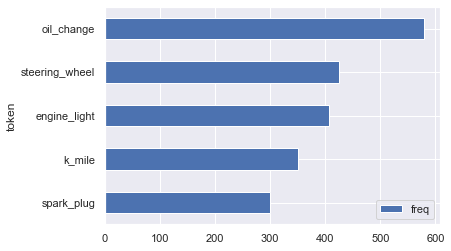

In [189]:
count_words(df, 'noun_phrases').head(5).plot(kind='barh').invert_yaxis()

In [191]:
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items))

con = sqlite3.connect(db_name)
df.to_sql("posts_nlp", con, index=False, if_exists='replace')
con.close()

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:2778: UserWarning: The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.
  sql.to_sql(


In [192]:
df

id      subreddit  \
0      8f73s7         Harley   
1      5s0q8r        Mustang   
2      5z3405     Volkswagen   
3      7df18v          Lexus   
4      5tpve8           volt   
...       ...            ...   
19995  7i2k6y        4Runner   
19996  83p2kv         Harley   
19997  7x722h           volt   
19998  7v2xmg          Lexus   
19999  8dxx3b  mercedes_benz   

                                                                 title  \
0                                                       No Club Colors   
1                                                Roush vs Shleby GT500   
2                             2001 Golf Wagon looking for some insight   
3                                          IS 250 Coolant Flush/Change   
4                                            Gen1 mpg w/ dead battery?   
...                                                                ...   
19995                                                  Bilstein Shocks   
19996                  Question on potential purchase of crashed bike.   
19997                          Got our first warning light on our dash   
19998                                          Any IS models to avoid?   
19999  Advice please. Looking at a 2011 E550 with 71K miles. Good car?   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           raw text  \
0      Funny story. I went to college in Las Vegas. This was before I knew anything about motorcycling whatsoever. Me and some college buddies would always go out on the strip to the dance clubs. We always ended up at a bar called Hogs &amp; Heifers. It's worth noting the females working there can outdrink ANYONE. Anyway, there was a sign on the front door that read 'No Club Colors'. So we lose our ties and blazers before heading there. Also we assumed bright colors like red, yellow, green etc were not allowed. So we would always bring an xtra t-shirt and pair of jeans. This went on for years! Looking back now on how naive we were, it's just hilarious. I was never able to walk out of that bar....had to crawl out! So much booze. <lb><lb>Cheers. Ride safe, boys!    
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                  I am trying to determine which is faster, and I've seen the dealership video with the two racing(Roush won 2/3). But I was wondering if it was just because of the bigass supercharger in the Roush. <lb><lb><lb>Also I can't find the same specs on any two websites, what are some trustworthy sources for this kind of thing?   
2                                                                                                                                                                                                                                                                                                                                    Hello! <lb><lb>Trying to find some information on replacing a 2001 Golf Wagon starter (